# Purpose: Use dimensions.ai as the source of summary statistics of research publication by category, try to identify categories with highest growth (hence more potential)
last updated on 3/18/2023
1. Collect research cateogies and codes from https://app.dimensions.ai/browse/categories/publication/for
2. Visit each catogory and crawl research data
3. Analyze growth trend and compare across time and different sectors

References: 
1. https://towardsdatascience.com/how-to-use-selenium-to-web-scrape-with-example-80f9b23a843a

In [ ]:
import requests
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import re
HEADERS = ({'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) \AppleWebKit/537.36 (KHTML, like Gecko) \Chrome/90.0.4430.212 Safari/537.36','Accept-Language': 'en-US, en;q=0.5'})

In [ ]:
def get_soup(url,HEADERS):
    r = requests.get(url, headers=HEADERS).text
#     soup = BeautifulSoup(r, 'html.parser')
    soup = BeautifulSoup(r, 'lxml')
    return soup
soup= get_soup("https://app.dimensions.ai/browse/categories/publication/for",HEADERS)

In [ ]:
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup

soup = BeautifulSoup(urlopen("https://app.dimensions.ai/browse/categories/publication/for"))
result = soup.find_all("div", {"class":"mycategories"})

for res in result:
    print(res.decode_contents().strip())

Note: used selenium instead of BeautifulSoup because the category data was loaded after loading the site

In [1]:
# use the latest selenium 4, there are syntax changes from previous version
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import pickle

In [ ]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

In [ ]:
driver.get("https://app.dimensions.ai/browse/categories/publication/for")

In [ ]:
all_href = driver.find_elements(By.XPATH,  "//*[contains(@href, '/discover/publication?and_facet_for')]")

In [ ]:
# Find by div class failed because can't collect the href links
# level_1 = driver.find_elements("xpath",'//div[@class="sc-2f5ewc-3 bVEbpe textcrop"]')
# level_2 = driver.find_elements("xpath",'//div[@class="sc-2f5ewc-0 gIuuzb textcrop"]')

In [ ]:
research_collection = {}
for i in range(len(all_href)):
    research_collection[all_href[i].text] = all_href[i].get_attribute('href')

In [ ]:
research_data = {}
for item in list(research_collection.items()):
    name, link = item[0],item[1]
    driver.get(link.replace("discover/publication?","analytics/publication/overview/timeline?"))
    WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, "//*[@id='analytics_infinite_scroll_container']/div[2]/div[2]/div[2]/div[2]/fieldset/span[3]"))).click()
    WebDriverWait(driver, 10)
    # Reference: https://www.softwaretestingmaterial.com/how-to-handle-web-tables-in-selenium-python/
    columns_header = driver.find_elements(By.XPATH,"//table[@class= 'table table--analytical']/thead/tr/th")
#     row_header = driver.find_elements(By.XPATH,"//table[@class= 'table table--analytical']/tbody/tr/th")
    row_data = driver.find_elements(By.XPATH,"//table[@class= 'table table--analytical']/tbody/tr/td")
    data = {}
    for i in range(len(columns_header)):
        data[columns_header[i].text] = row_data[i].text
    research_data[name] = data

In [ ]:
# Reference: https://pynative.com/python-save-dictionary-to-file/
with open('research_data.pkl', 'wb') as fp:
    pickle.dump(research_data, fp)

In [2]:
with open('research_data.pkl', 'rb') as fp:
    research_data = pickle.load(fp)

In [ ]:
driver.close()

In [47]:
import pandas as pd
df_data = pd.DataFrame(columns = ['Code', 'Name', 2014, 2015,2016,2017,2018,2019,2020,2021,2022,2023])

In [48]:
for key,value in research_data.items():
    value_data = { int(k):int(v.replace(",","")) for k,v in value.items() }
    code = int(key.split()[0])
    df = pd.DataFrame([value_data])
    df['Code'] = code
    df['Name'] = key
    df_data = pd.concat([df_data,df],ignore_index=True)

In [49]:
df_data

,Code,Name,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,30,"30 Agricultural, Veterinary and Food Sciences",118371,123457,137002,148096,161826,184859,217639,243485,244872,45115
1,3001,3001 Agricultural Biotechnology,6186,6232,6905,6995,7020,7294,8437,8893,9258,1692
2,3002,"3002 Agriculture, Land and Farm Management",9306,9362,10453,11019,11813,13581,17255,19771,20196,3672
3,3003,3003 Animal Production,12128,12644,16002,15932,16758,20476,24038,25995,24224,4093
4,3004,3004 Crop and Pasture Production,18097,19903,23094,25390,28034,31952,40340,45145,47298,8849
...,...,...,...,...,...,...,...,...,...,...,...,...
188,5201,5201 Applied and Developmental Psychology,17118,17933,19726,20377,20163,20894,22431,24102,23727,4421
189,5202,5202 Biological Psychology,44033,46636,47441,52569,48850,54165,55530,59339,58201,10268
190,5203,5203 Clinical and Health Psychology,31045,32678,34122,36455,35291,38717,46695,47916,49316,8680
191,5204,5204 Cognitive and Computational Psychology,14525,15159,15733,16911,18055,18820,19634,20441,20886,3675


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<Figure size 36000x14400 with 0 Axes>

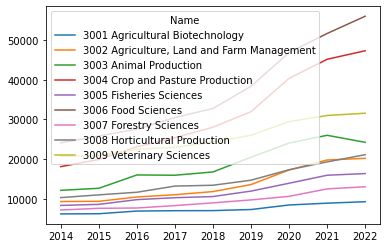

In [54]:
import matplotlib.pyplot as plt
plt.figure()
plt.figure(figsize=(500,200))
df_plot = df_data[(df_data['Code'].astype(str).str.len() == 4) & (df_data['Code'].astype(str).str.startswith("30"))].set_index("Name")
df_plot = df_plot.iloc[:, 1:-1]
df_plot.T.plot()

In [46]:
display(df_plot.T)

Name,Agricultural Biotechnology,"Agriculture, Land and Farm Management",Animal Production,Crop and Pasture Production,Fisheries Sciences,Food Sciences,Forestry Sciences,Horticultural Production,Veterinary Sciences,Biochemistry and Cell Biology,...,Nuclear and Plasma Physics,Particle and High Energy Physics,Quantum Physics,Space Sciences,Synchrotrons and Accelerators,Applied and Developmental Psychology,Biological Psychology,Clinical and Health Psychology,Cognitive and Computational Psychology,Social and Personality Psychology
2014,6186,9306,12128,18097,8325,24096,7171,10291,20701,93107,...,39168,30893,26805,12894,11818,17118,44033,31045,14525,14815
2015,6232,9362,12644,19903,8591,25824,7595,10988,20890,91151,...,40702,32472,26869,13833,12909,17933,46636,32678,15159,15159
2016,6905,10453,16002,23094,9783,27536,7677,11645,22435,91966,...,42314,33432,29552,13899,13966,19726,47441,34122,15733,16254
2017,6995,11019,15932,25390,10271,30475,8285,13201,22968,94770,...,39309,33729,31357,14637,12465,20377,52569,36455,16911,17065
2018,7020,11813,16758,28034,10563,32744,8975,13408,24246,105114,...,37690,33329,32916,15824,12626,20163,48850,35291,18055,17100
2019,7294,13581,20476,31952,11935,38344,9717,14679,26020,109462,...,38193,32757,35737,14338,12632,20894,54165,38717,18820,18431
2020,8437,17255,24038,40340,13913,46856,10613,17318,29433,118906,...,38554,32035,38659,14116,13426,22431,55530,46695,19634,20390
2021,8893,19771,25995,45145,15930,51644,12488,19287,30988,123886,...,37517,33514,40656,14410,11667,24102,59339,47916,20441,22835
2022,9258,20196,24224,47298,16349,55990,13028,21111,31557,127276,...,36365,33368,41258,14466,11185,23727,58201,49316,20886,21938
